This workbook provides several useful plotting functions for visualizing weather data and the route data produced in **Sailboat1.py** and **SailboatQ.py**

In [1]:
import pandas as pd
import numpy as np
import pygrib
import matplotlib.pyplot as plt
import netCDF4
import math
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.offline as py_off
import plotly.graph_objs as go
from mpl_toolkits.basemap import Basemap

In [2]:
weather = 'https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs20200614/gfs_0p25_1hr_00z'
file = netCDF4.Dataset(weather)
date = weather.split('/')[5].split("2020")[1]
raw_lat  = np.array(file.variables['lat'][:])
raw_lon  = np.array(file.variables['lon'][:])
raw_wind = np.array(file.variables['gustsfc'][1,:,:])
raw_wind_u = np.array(file.variables['ugrd10m'][1,:,:])
raw_wind_v = np.array(file.variables['vgrd10m'][1,:,:])
file.close()

In [3]:
# set boundaries for race course
min_lat = 0
max_lat = 50
min_lon = 180
max_lon = 242

In [4]:
# apply boundaries
lat_to_use = np.argwhere((raw_lat >= min_lat) & (raw_lat <= max_lat))
min_row = int(lat_to_use[0])
max_row = int(lat_to_use[-1])

lon_to_use = np.argwhere((raw_lon >= min_lon) & (raw_lon <= max_lon))
min_col = int(lon_to_use[0])
max_col = int(lon_to_use[-1])

lat = raw_lat[lat_to_use].reshape(len(lat_to_use))
lon = raw_lon[lon_to_use].reshape(len(lon_to_use))

In [5]:
# filter weather data
wind = raw_wind[min_row:max_row+1, min_col:max_col+1]
wind_u = raw_wind_u[min_row:max_row+1, min_col:max_col+1]
wind_v = raw_wind_v[min_row:max_row+1, min_col:max_col+1]

In [6]:
# create dataframe of wind angle (opposite to wind vector)
wind_angle = np.zeros([len(wind), len(wind[0])])

for i in range(0, len(wind_u)):
    for j in range (0, len(wind_v)):
        wind_angle[i][j] = 180 + math.degrees(math.atan2(raw_wind_u[i][j], raw_wind_v[i][j]))

Quiver plots can be used to visualize the magnitude and direction of the wind vector using Plotly

In [7]:
# quiver plot of wind
def windquiver(plotevery):
    # filtering wind so "plotting every" so many data points, otherwise too many windvector points to plot
    wind_v_red = wind_v[::plotevery,::plotevery]
    wind_u_red = wind_u[::plotevery,::plotevery]
    lon_red = lon[::plotevery]
    lat_red = lat[::plotevery]
    x, y = np.meshgrid(lon_red,lat_red)
    f = ff.create_quiver(x, y, wind_u_red, wind_v_red)
    f.show()

In [8]:
windquiver(10)

In [9]:
# syntax for dead wind, only call if using dead zone
# dead_wind = wind*1

# dead_min_row = 65
# dead_max_row = 90
# dead_min_col = 110
# dead_max_col = 115

# dead_wind[dead_min_row:dead_max_row, dead_min_col:dead_max_col] = 0.1

# dead_min_row = 85
# dead_max_row = 105
# dead_min_col = 125
# dead_max_col = 130

# dead_wind[dead_min_row:dead_max_row, dead_min_col:dead_max_col] = 0.1

# wind = dead_wind

The routeplotter function can be used to visualize the route data produced by **Sailboat1.py** and **SailboatQ.py** on a map using Plotly

In [10]:
def routeplotter(route_file):
    racemap = []
    route = pd.read_csv(route_file)
    for i in range(0, len(route)-1):
        for j in range(0, len(route.values[0])-1):
            if route.values[i][j] > 0:
                lati = lat[i]
                lonj = lon[j]
                val = route.values[i][j]
                racemap.append((lati,lonj, val))
    racemap_df = pd.DataFrame(racemap, columns = ["lat", "lon", "val"])
    str = route_file
    lr = float(str.split("lr")[1].split("_")[0])
    expr = float(str.split("_er")[1].split("_")[0])
    rounds = str.split("_r")[1].split(".")[0]
    fig = px.scatter_mapbox(racemap_df, lat="lat", lon="lon", color="val", height = 600, width = 900)
    fig.update_layout(mapbox_style="open-street-map", title = 'Route plotter, LR = {}, ExpR = {}, rounds = {}'
                      .format(lr, expr, rounds), titlefont=dict(size=20)) 
    fig.show()

In [11]:
routeplotter('/Users/rachelbeal/PycharmProjects/FasTack/output/FinalRoutes/route_lr0.5_er0.8_r10000_gamma0.95_0615.csv')


In [14]:
def quiverroute(route_file, plotevery):
    racemap = []
    route = pd.read_csv(route_file)
    for i in range(0, len(route)-1):
        for j in range(0, len(route.values[0])-1):
            if route.values[i][j] > 0:
                lati = lat[i]
                lonj = lon[j]
                val = route.values[i][j]
                racemap.append((lati,lonj, val))
    racemap_df = pd.DataFrame(racemap, columns = ["lat", "lon", "val"])
    fig = px.scatter(x = racemap_df.lon, y = racemap_df.lat)
#     to compare two race routes, uncomment the code below and add a "route_file2" arg to the function definition
#     racemap2 = []
#     route2 = pd.read_csv(route_file2)
#     for i in range(0, len(route2)-1):
#         for j in range(0, len(route2.values[0])-1):
#             if route2.values[i][j] > 0:
#                 lati = lat[i]
#                 lonj = lon[j]
#                 val = route2.values[i][j]
#                 racemap2.append((lati,lonj, val))
#     racemap2_df = pd.DataFrame(racemap2, columns = ["lat", "lon", "val"])
#     fig2 = px.scatter(x = racemap2_df.lon, y = racemap2_df.lat)
#     fig.add_trace(fig2.data[0])
    wind_v_red = wind_v[::plotevery,::plotevery]
    wind_u_red = wind_u[::plotevery,::plotevery]
    lon_red = lon[::plotevery]
    lat_red = lat[::plotevery]
    x, y = np.meshgrid(lon_red,lat_red)
    f = ff.create_quiver(x, y, wind_u_red, wind_v_red)
    fig.add_trace(f.data[0])
    fig.show()

In [15]:
quiverroute('/Users/rachelbeal/PycharmProjects/FasTack/output/wwinvec_parmtest/route_lr0.5_er0.8_r10000_gamma0.95.csv', 5)


The windvector function can be used to plot wind vector information from any date available on the GrADS server

In [20]:
def windvector(date):
    url = "https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25_1hr/gfs2020"+ date + "/gfs_0p25_1hr_00z"
    file = netCDF4.Dataset(url)
    lat = file.variables['lat'][:]
    lon = file.variables['lon'][:]
    print("still reading gribs")
    wind = file.variables['gustsfc'][1, :, :]
    wind_u = file.variables['ugrd10m'][1, :, :]
    wind_v = file.variables['vgrd10m'][1, :, :]
    wind_v_red = wind_v[::5,::5]
    wind_u_red = wind_u[::5,::5]
    wind_red = wind[::5,::5]
    lon_red = lon[::5]
    lat_red = lat[::5]
    
    fig = plt.figure(figsize=(15,15))
   
    m = Basemap(projection='mill',lat_ts=1,llcrnrlon=180, \
          urcrnrlon=260,llcrnrlat=10,urcrnrlat=50, \
          resolution='c')

    x, y = m(*np.meshgrid(lon_red,lat_red))

    m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0], fontsize=30)
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1],fontsize=30)

    m.quiver(x, y, 
        wind_u_red, wind_v_red, wind_red,
        cmap=plt.cm.jet, scale=500)

    m.bluemarble()

    cb = m.colorbar(location='right')
    cb.set_label(label='wind speed (m/s)', size=30)
    cb.ax.tick_params(labelsize=30) 

    plt.show()

still reading gribs


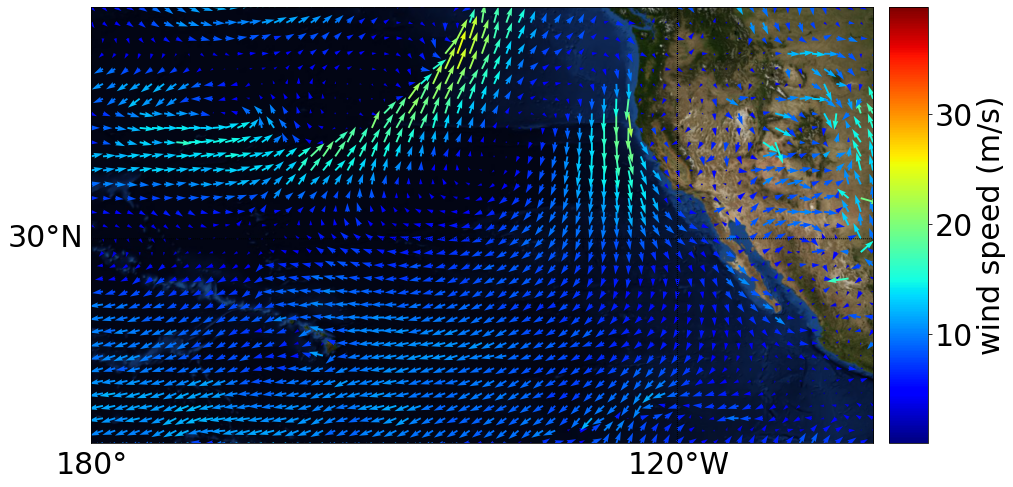

In [21]:
windvector("0618")